In [31]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
import scipy as sp
from numpy.fft import fft, ifft, fftshift, fftn, rfftn, rfft, irfft, irfftn

from scipy.signal import convolve, fftconvolve

In [2]:
import sigflux
from sigflux.wave import cwtlets
from sigflux import cwt

In [3]:
def iplot(sig):
    plt.plot(np.real(sig))
    plt.plot(np.imag(sig))
    

0.276560867874
0.276560867874
-3.33852953963e-16
ricka
0.276560867874
-3.33852953963e-16


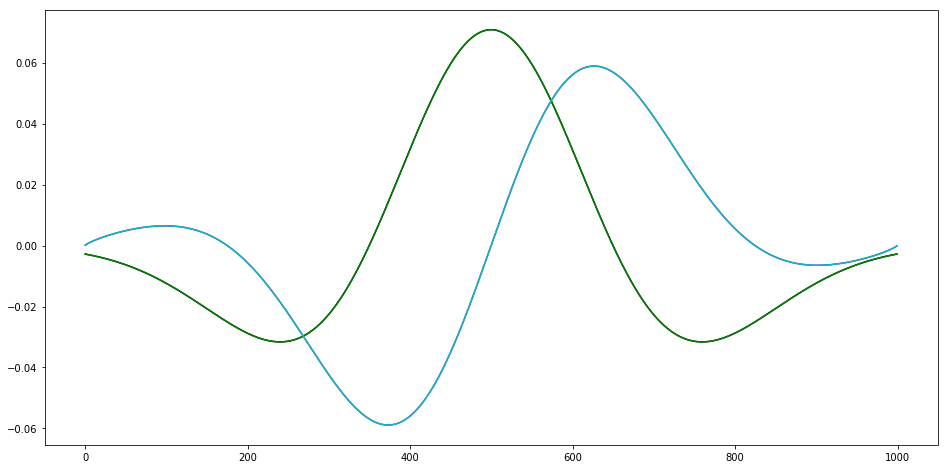

In [4]:
rcParams['figure.figsize'] = 16,8
n = 1000
a = 150
w = 500
win = slice((n//2) - w, (n//2) + w)
hat = cwtlets.hatlet(n, a)
ric = signal.ricker(n, a)
rica = signal.hilbert(ric)

plt.plot(ric[win], 'k')
# plt.plot(np.real(hat)[win], 'r')
plt.plot(np.imag(hat)[win], 'm')

plt.plot(np.real(rica)[win], 'g')
plt.plot(np.imag(rica)[win], 'c')
print(sp.integrate.cumtrapz(ric)[-1])
print(sp.integrate.cumtrapz(np.real(hat))[-1])
print(sp.integrate.cumtrapz(np.imag(hat))[-1])
print('ricka')
print(sp.integrate.cumtrapz(np.real(rica))[-1])
print(sp.integrate.cumtrapz(np.imag(rica))[-1])

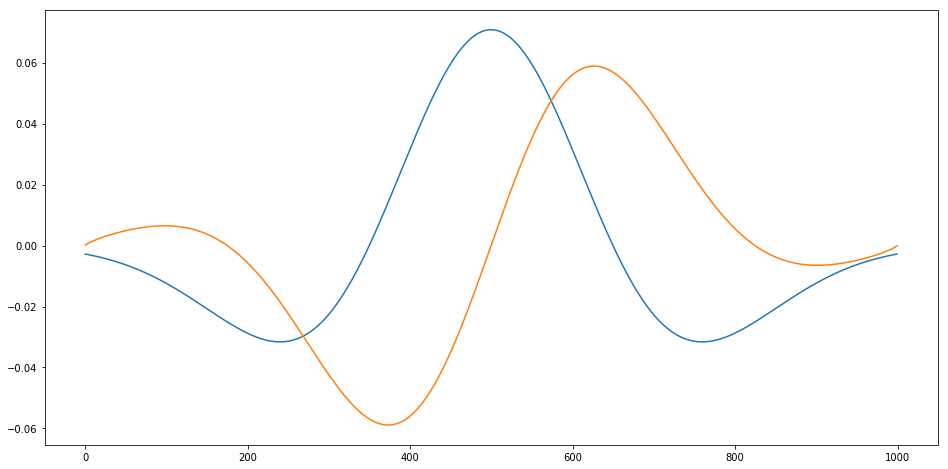

In [5]:
iplot(rica)

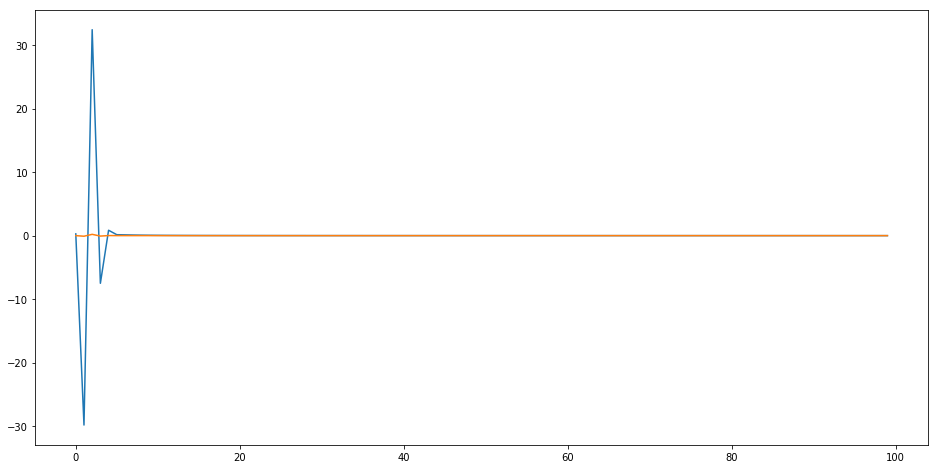

In [6]:
iplot(fft(rica)[:100])

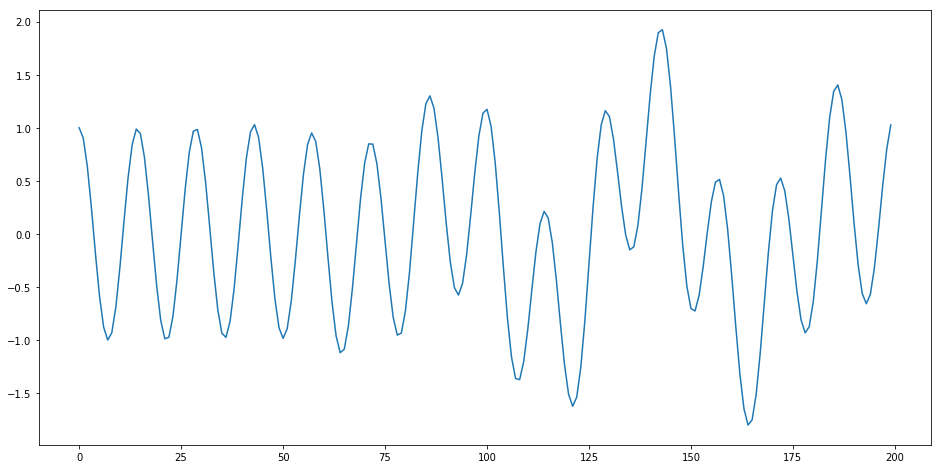

In [7]:
N = 200
t = np.linspace(-1, 1, N, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
plt.plot(sig)

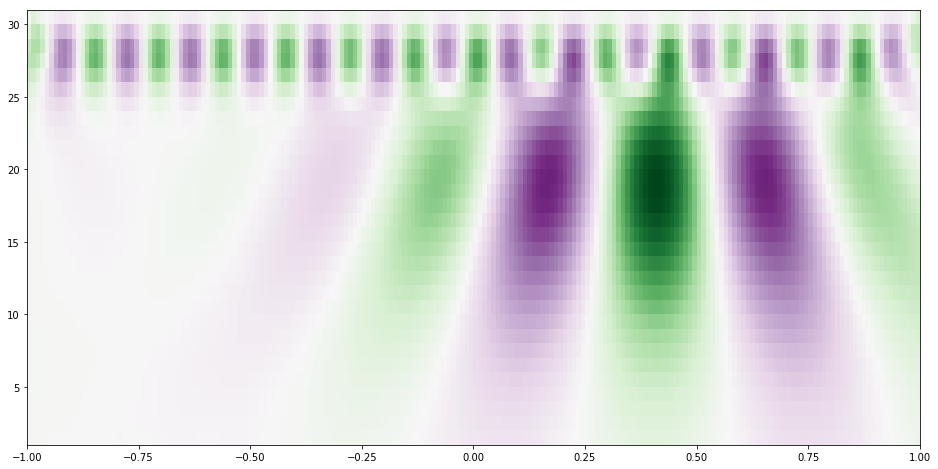

In [8]:
widths = np.arange(1, 31)
cwtmatr = signal.cwt(sig, signal.ricker, widths)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

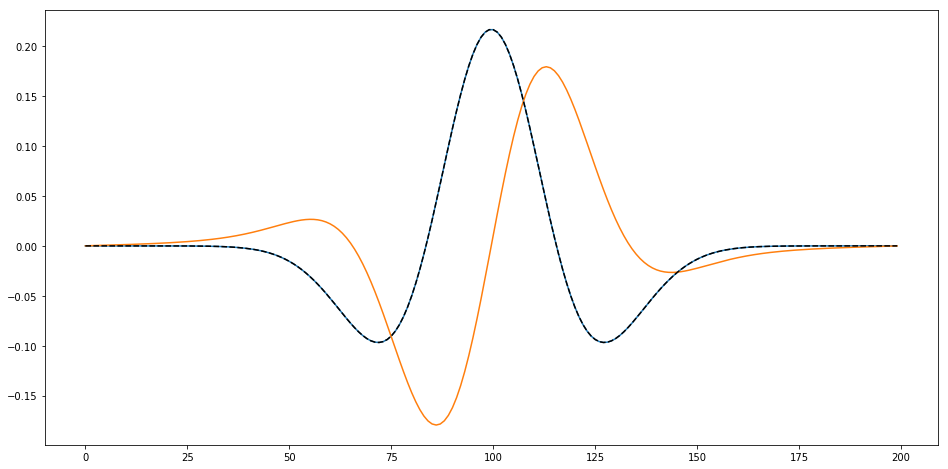

In [9]:
wav = cwtlets.hatlet(len(t), 16)
ric = signal.ricker(len(t), 16)
iplot(wav)
plt.plot(ric, 'k--')

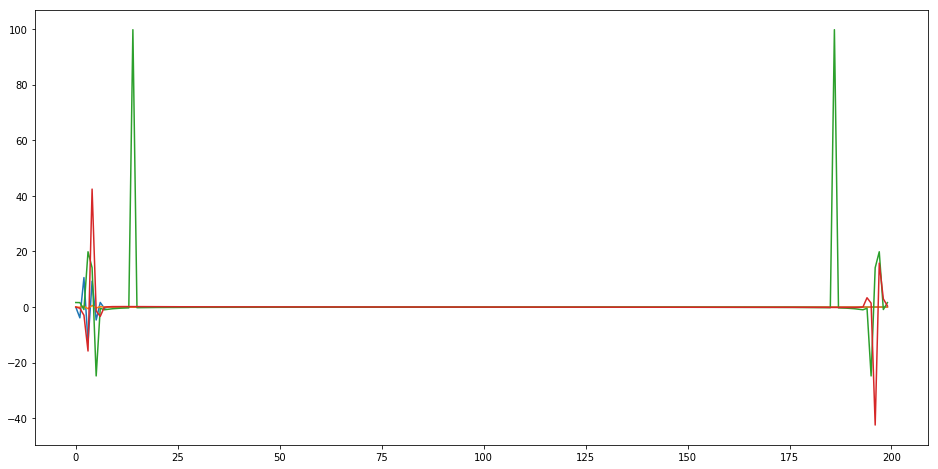

In [10]:
iplot(fft(wav))
iplot(fft(sig))

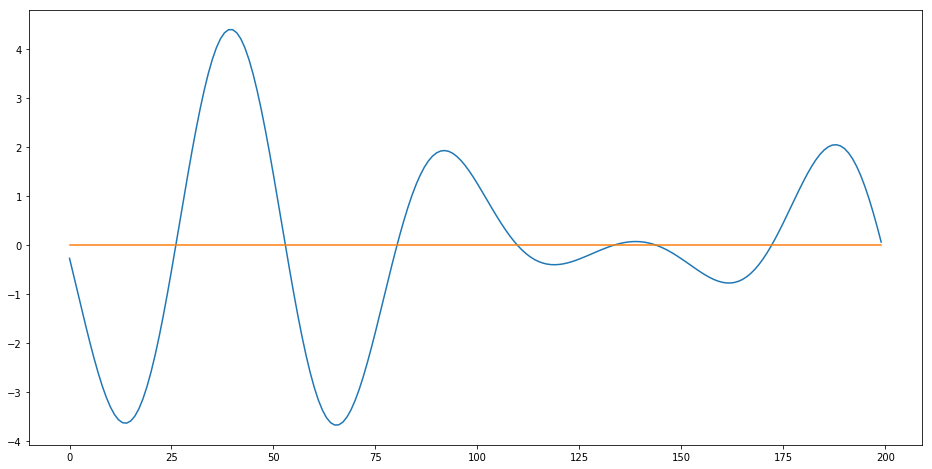

In [11]:
iplot(ifft(fft(ric) * fft(sig)))

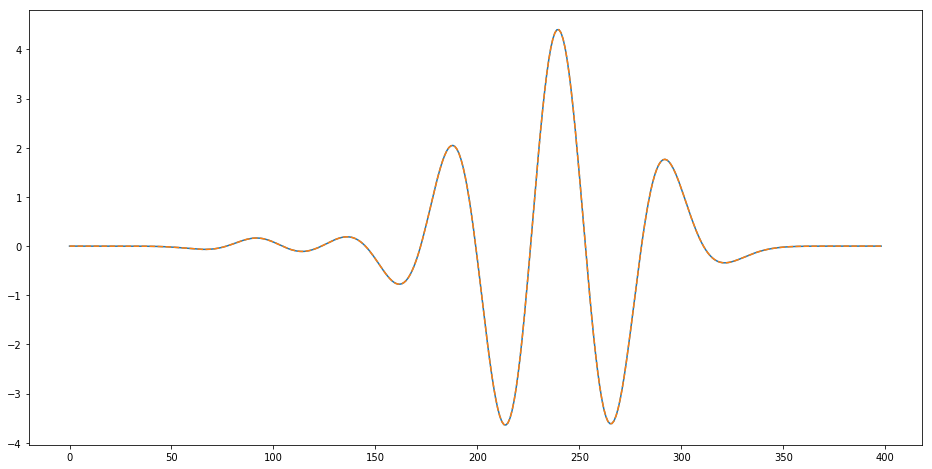

In [12]:
plt.plot(convolve(sig, np.real(wav)))
plt.plot(fftconvolve(sig, np.real(wav)), '--')

200 200 200
200 200


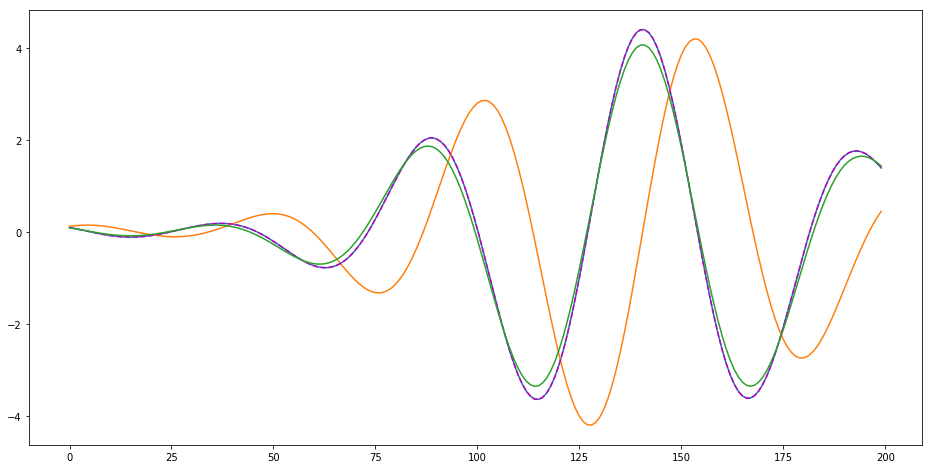

In [63]:
rcParams['figure.figsize'] = 16,8
a = 16
mode = 'same'
wav = cwtlets.hatlet(len(t), a)
ric = signal.ricker(len(t), a)
conv1 = convolve(sig, ric, mode=mode)
conv2 = fftconvolve(sig, wav, mode=mode)
iplot(conv2)
plt.plot(conv1, 'm--')
plt.plot(cwtmatr[a])
print(len(t), len(conv1), len(conv2))
print(len(wav), len(ric))

(200,) (200,)
Shape:  [399] Fslice (slice(0, 399, None),)
[400]


/home/mike/ve/keras/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


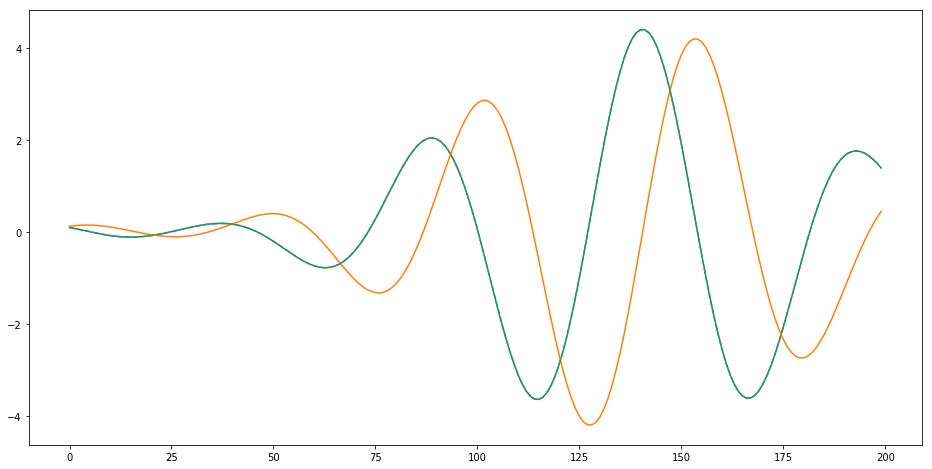

In [171]:
def _centered(arr, newshape):
    # Return the center newshape portion of the array.
    newshape = np.asarray(newshape)
    currshape = np.array(arr.shape)
    startind = (currshape - newshape) // 2
    startind -= 1 # this is a hack to get bogo_fftconv to behave the same. 
    endind = startind + newshape
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]


def bogo_fftconv(in1, in2, mode='full', complex_result=True):
    """Reimplemenation of scipy.signal.fftconv, so I can play around with its insides. Missing some functionality of the original
    """
    s1 = np.array(in1.shape)
    s2 = np.array(in2.shape)
    shape = s1 + s2 - 1
    fslice = tuple([slice(0, int(sz)) for sz in shape])
    print(in1.shape, in2.shape)
    print('Shape: ', shape, 'Fslice', fslice)
    if not complex_result:
        assert 0, 'not ready yet'
        try:
            sp1 = np.fft.rfftn(in1, fshape)
            sp2 = np.fft.rfftn(in2, fshape)
            ret = (np.fft.irfftn(sp1 * sp2, fshape)[fslice].copy())
        finally:
            print('bork?')
            pass
#     fftn = sp.fftpack.fftn
#     ifftn = sp.fftpack.ifftn
    fftn = np.fft.fftn
    ifftn = np.fft.ifftn
    
    # Speed up FFT by padding to optimal size for FFTPACK
    fshape = [sp.fftpack.helper.next_fast_len(int(d)) for d in shape]
    print(fshape)
    
    sp1 = fftn(in1, fshape)
    sp2 = fftn(in2, fshape)
    ret = ifftn(sp1 * sp2)#[fslice].copy()
    
    if mode == "full":
        return ret
    elif mode == "same":
        return _centered(ret, s1)
    elif mode == "valid":
        return _centered(ret, s1 - s2 + 1)
    else:
        raise ValueError("Acceptable mode flags are 'valid',"
                         " 'same', or 'full'.")


result = bogo_fftconv(sig, wav, 'same')    
iplot(result)
plt.plot(conv2, '--')


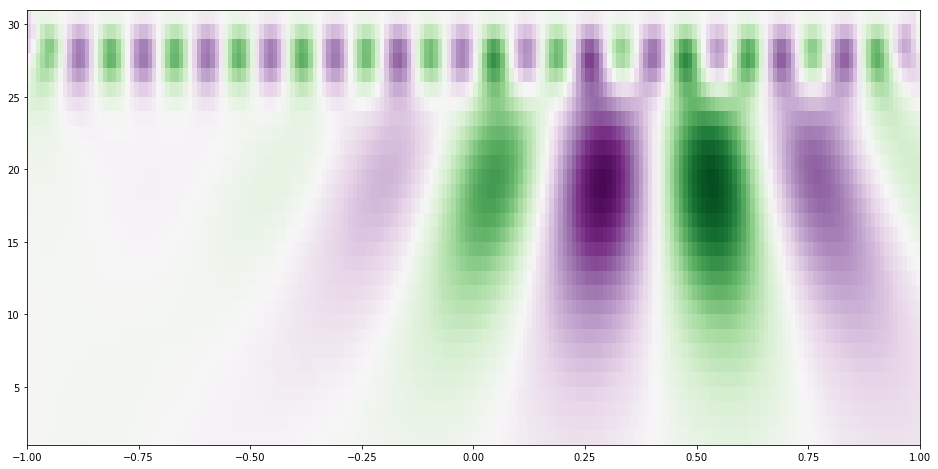

In [207]:
widths = np.arange(1, 31)
cwtmatr = sigflux.cwt(sig, signal.ricker, widths)
cwtmatr2 = sigflux.cwt(sig, cwtlets.hatlet, widths)
plt.imshow(np.imag(cwtmatr2), extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.show()

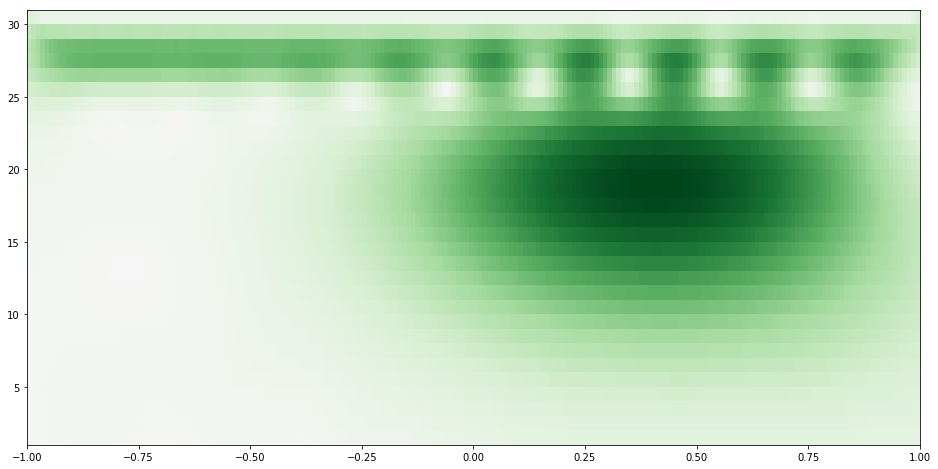

In [24]:
plt.imshow(np.abs(cwtmatr2), extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

In [16]:
np.isclose(cwtmatr, np.real(cwtmatr2))

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

/home/mike/ve/keras/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


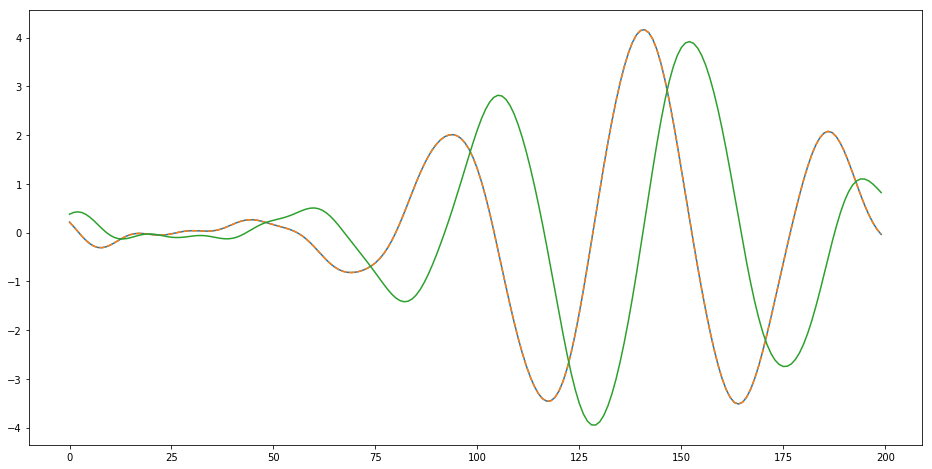

In [17]:
a = 8
plt.plot(cwtmatr[a])
plt.plot(cwtmatr2[a], '--')
plt.plot(np.imag(cwtmatr2)[a])

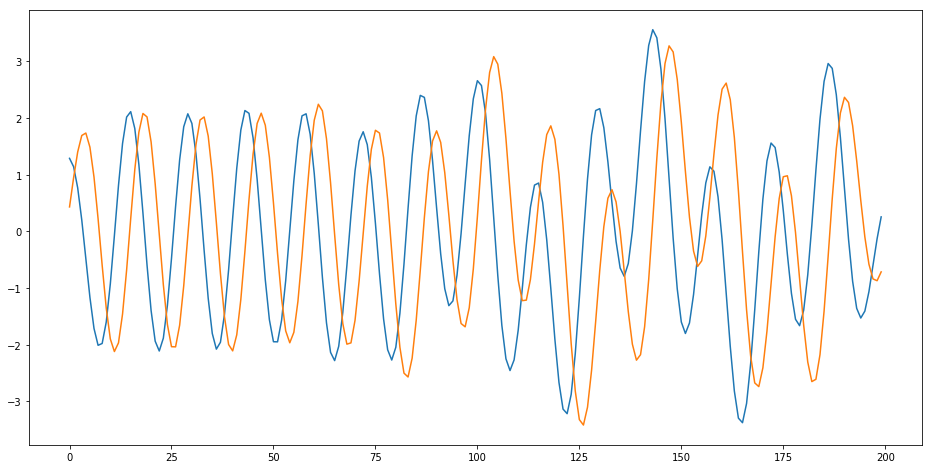

In [23]:
iplot(cwtmatr2[4])

In [244]:
def filterbank_ctw(data, wavelet, widths):
    N = len(data)
    wavelet_data = wavelet(10, 2)
    output = np.zeros([len(widths), len(data)], dtype=wavelet_data.dtype)
    wavebank = []
    for width in widths:
        wave = wavelet(min(10 * width, N), width).reshape(1,-1)
        p = (N - wave.shape[1]) // 2
        q = N - wave.shape[1] - p
        wave = np.pad(wave, [(0,0), (p, q)], 'constant')
        wavebank.append(wave)
#         print(p, wave.shape)
        
    wavebank = np.concatenate(wavebank, axis=0)
#     print(wavebank.shape)

#     for ind, width in enumerate(widths):
#         wavelet_data = wavelet(min(10 * width, len(data)), width)
#         output[ind, :] = fftconvolve(data, wavelet_data,
#                                   mode='same')
    return wavebank

In [190]:
widths = np.arange(1, 31)
# cwtmatr = sigflux.cwt(sig, signal.ricker, widths)
xform = filterbank_ctw(sig, cwtlets.hatlet, widths)

In [191]:
xform.shape, xform.dtype

((30, 200), dtype('complex128'))

In [192]:
bank = np.fft.fftn(xform, [400], axes=[1])
type(bank)
# plt.imshow(bank)

numpy.ndarray

In [193]:
bank.shape

(30, 400)

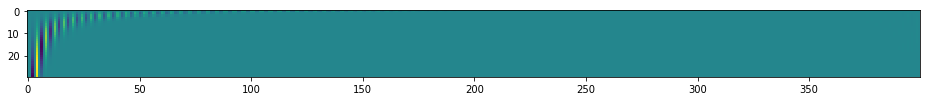

In [194]:
plt.imshow(np.real(bank))

/home/mike/ve/keras/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


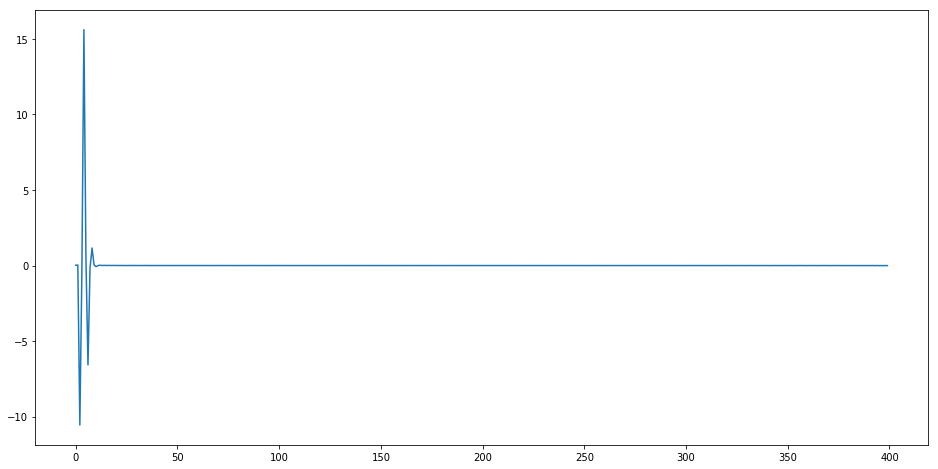

In [195]:
plt.plot(bank[25])

/home/mike/ve/keras/lib/python3.5/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


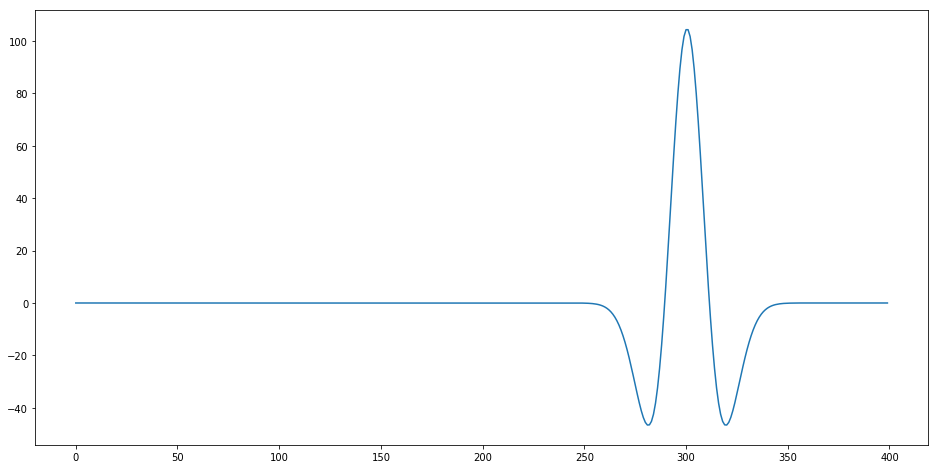

In [196]:
plt.plot(fft(bank[10]))

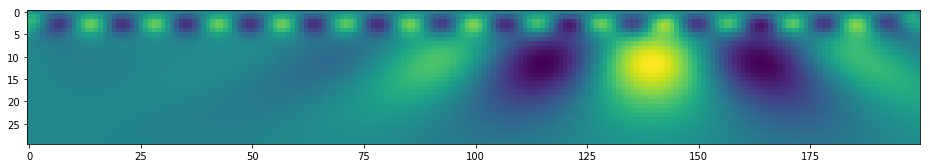

In [197]:
conv = (fftn(sig, [400]) * bank)
conv.shape
img = np.fft.ifftn(conv, axes=[1])[:,100:-100]
plt.imshow(np.real(img))

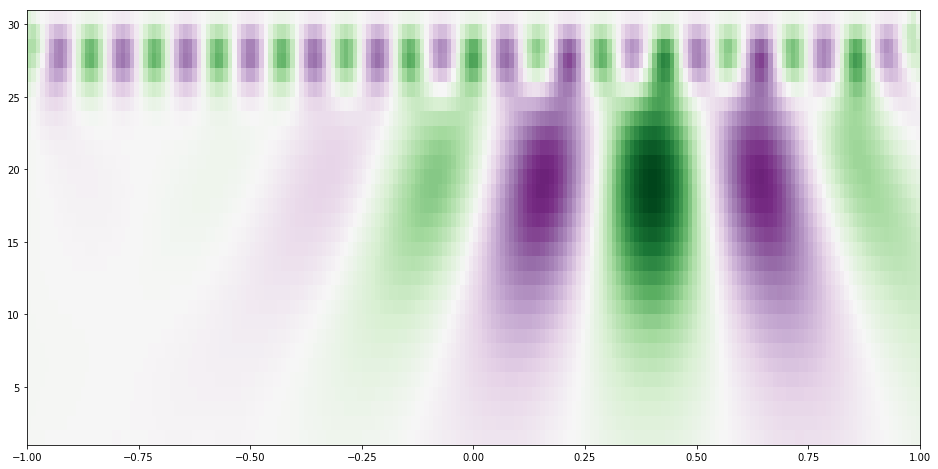

In [198]:
cw = np.real(img)
plt.imshow(cw, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
            vmax=abs(cw).max(), vmin=-abs(cw).max())

In [211]:
np.pad(sig, [(100,100)], 'constant').shape

(400,)

In [251]:
def turbo_cwt(data, wavelet, widths, mode='same', complex_result=True):
    """Faster Continuous Wavelet Transform
    """
    assert data.ndim == 1, "Only supports 1D input currently"
    siglen = data.shape[0] # same as widths, since we built it. Actually we need to pad the data first
    in1 = data# np.pad(data, [(siglen//2, siglen//2)], 'constant')
    in2 = filterbank_ctw(data, wavelet, widths)
    s1 = np.array(in1.shape)
    s2 = np.array(in2.shape)
    shape = [data.shape[0]*2]
    fslice = tuple([slice(0, int(sz)) for sz in shape])
#     print(in1.shape, in2.shape)
#     print('Shape: ', shape, 'Fslice', fslice)

    fftn = sp.fftpack.fftn
    ifftn = sp.fftpack.ifftn
    
    # Speed up FFT by padding to optimal size for FFTPACK
    fshape = [sp.fftpack.helper.next_fast_len(int(d)) for d in shape]
#     print('in1', in1.shape, 'fshape', fshape)
    
    sp1 = fftn(in1, [shape[0]])
    sp2 = fftn(in2, [shape[0]], axes=[1])
    ret = ifftn(sp1 * sp2, axes=[1])#[fslice].copy()
    
    if mode == "full":
        return ret
    elif mode == "same":
        return _centered(ret, s1)
    elif mode == "valid":
        return _centered(ret, s1 - s2 + 1)
    else:
        raise ValueError("Acceptable mode flags are 'valid',"
                         " 'same', or 'full'.")

(200,) (256, 200)
Shape:  [400] Fslice (slice(0, 400, None),)
in1 (200,) fshape [400]


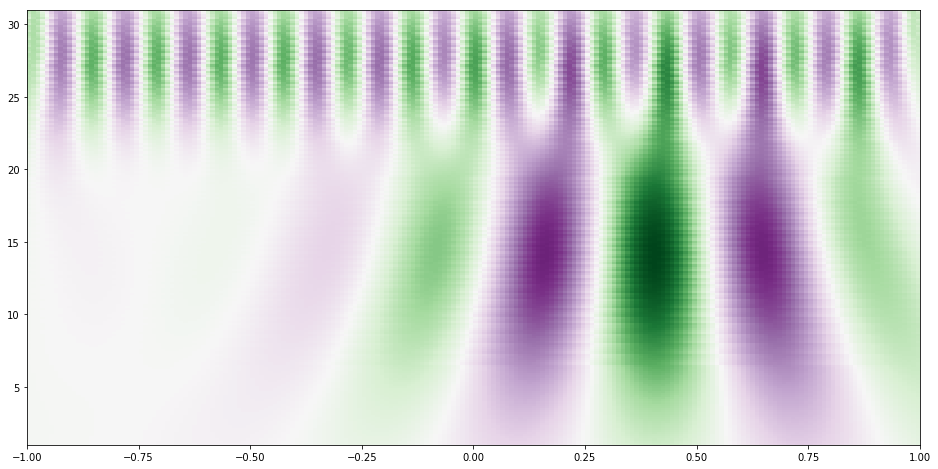

In [246]:
# old_cw = np.real(signal.cwt(sig, signal.ricker, widths))
cw = np.real(turbo_cwt(sig, signal.ricker, widths))
plt.imshow(cw, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
            vmax=abs(cw).max(), vmin=-abs(cw).max())
plt.figure()
# plt.imshow(old_cw, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
#             vmax=abs(cw).max(), vmin=-abs(cw).max())

In [263]:
widths = np.linspace(1, 32**0.5, 256)**2

In [264]:
%timeit signal.cwt(sig, signal.ricker, widths)


9.76 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [265]:
%timeit turbo_cwt(sig, signal.ricker, widths)

21.5 ms ± 330 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [266]:
%timeit turbo_cwt(sig, cwtlets.hatlet, widths)

31.5 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
